In [84]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math, os
import glob
from sklearn.decomposition import PCA
# from sklearn.preprocessing import 
# from collections import defaultdict

In [85]:
os.listdir(directory)

['arjun_walk1.csv',
 'arjun_walk2.csv',
 'arj_jog1.csv',
 'arj_jog2.csv',
 'jk_walk1.csv',
 'jk_walk2.csv']

In [86]:
def dataframe_of_CSI(directory):
    # Create empty DataFrames for walk, run, and jog
    df_walk = pd.DataFrame()
    df_run = pd.DataFrame()
    df_jog = pd.DataFrame()

    # Loop through each file in the directory
    for file in os.listdir(directory):
        # Check if the file is a CSV file and contains "walk", "run", or "jog" in the name
        if file.endswith(".csv") and ("walk" in file or "run" in file or "jog" in file):
            # Read the CSV file and extract the CSI_DATA column
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            print(df.sig_mode.value_counts())
            csi_rows_raw = []

            ## Filtering can be done using
            # df = df[(df["channel"]==6) & (df["secondary_channel"]==1)]

            for one_row in df['CSI_DATA']:
                one_row = one_row.strip("[]")
                csi_row_raw = [int(x) for x in one_row.split(" ") if x != '']
                csi_rows_raw.append(csi_row_raw)
        
            # Convert the list of lists to a DataFrame and append it to the appropriate DataFrame based on the file name
            csi_df = pd.DataFrame(csi_rows_raw)

            # Check which dataframe we are working on and concat the data
            if "walk" in file:
                df_walk = pd.concat([df_walk, csi_df], axis=0)
            elif "run" in file:
                df_run = pd.concat([df_run, csi_df], axis=0)
            else:
                df_jog = pd.concat([df_jog, csi_df], axis=0)
    return df_walk, df_run, df_jog

In [87]:
# Define the directory path where the CSV files are located
directory = "C:\\Users\\Dell\\Documents\\Wifi-Sensing-HAR\\data\\our_data"

walk_df, run_df, jog_df = dataframe_of_CSI(directory)

sig_mode
1    2276
0     785
Name: count, dtype: int64
sig_mode
1    2172
0     809
Name: count, dtype: int64
sig_mode
1    2485
0     713
Name: count, dtype: int64
sig_mode
1    1849
0     805
Name: count, dtype: int64
sig_mode
1    1625
0    1052
Name: count, dtype: int64
sig_mode
1    1914
0    1658
Name: count, dtype: int64


In [88]:
## Extract Amplitude and Phase from the dataframe
def convert_csi_to_amplitude_phase(df):
    total_amplitudes = []
    total_phases = []

    for i, value in enumerate(df.values):
        imaginary = []
        real = []
        amplitudes = [] 
        phases = []

        csi_one_row_lst = value.tolist()

         # Create list of imaginary and real numbers from CSI
        [imaginary.append(csi_one_row_lst[item]) if item%2==0 else real.append(csi_one_row_lst[item]) for item in range(len(csi_one_row_lst))]

        # Transform imaginary and real into amplitude and phase
        val = int(len(csi_one_row_lst)//2)
        for k in range(val):
            amplitudes.append(round(math.sqrt(float(imaginary[k])** 2 + float(real[k])** 2),4))
            phases.append(round(math.atan2(float(imaginary[k]), float(real[k])),4))
        total_amplitudes.append(np.array(amplitudes))
        total_phases.append(np.array(phases))
    
    total_amplitudes_df = pd.DataFrame(total_amplitudes)
    total_phases_df = pd.DataFrame(total_phases)

        
    return total_amplitudes_df, total_phases_df

#### Amplitude and Phase of Walking

In [89]:
## Extract walk amplitude and phase
walk_amplitudes_df, walk_phases_df = convert_csi_to_amplitude_phase(walk_df)

## Here, based on sig_mode, 802.11a/g/n received. Here we receive both 802.11a/g and 802.11n
## So, either 52 or 56 total sub-carrier would be useful. The first 4 and the last 4 are rejected as null guard.


## Amplitude
walk_df1_amps = walk_amplitudes_df.iloc[:,6:32]  # 6:32 for 802.11ag 4:32 for 802.11n
walk_df2_amps = walk_amplitudes_df.iloc[:,33:59] # 33:59 for 802.11ag 33:61 for 802.11n

walk_df_amps_final = pd.concat([walk_df1_amps, walk_df2_amps],axis=1)


## Phase
walk_df1_phase = walk_amplitudes_df.iloc[:,6:32]  # 6:32 for 802.11ag 4:32 for 802.11n
walk_df2_phase = walk_amplitudes_df.iloc[:,33:59] # 33:59 for 802.11ag 33:61 for 802.11n

walk_df_phase_final = pd.concat([walk_df1_phase, walk_df2_phase],axis=1)

### Amplitude and Phase of Jogging

In [90]:
## Extract jog amplitude and phase
jog_amplitudes_df, jog_phases_df = convert_csi_to_amplitude_phase(jog_df)

## Amplitude
jog_df1_amps = jog_amplitudes_df.iloc[:,6:32]  # 6:32 for 802.11ag 4:32 for 802.11n
jog_df2_amps = jog_amplitudes_df.iloc[:,33:59] # 33:59 for 802.11ag 33:61 for 802.11n

jog_df_amps_final = pd.concat([jog_df1_amps, jog_df2_amps],axis=1)


## Phase
jog_df1_phase = jog_amplitudes_df.iloc[:,6:32]  # 6:32 for 802.11ag 4:32 for 802.11n
jog_df2_phase = jog_amplitudes_df.iloc[:,33:59] # 33:59 for 802.11ag 33:61 for 802.11n

jog_df_phase_final = pd.concat([jog_df1_phase, jog_df2_phase],axis=1)

#### Moving Average of the data

In [91]:
# Moving average of the data
def moving_average(df, window_size):
    """"
    Compute the moving average with a window of size specified
    """

    rolling_mean = df.rolling(window=window_size).mean()
    downsampled = rolling_mean.iloc[window_size::window_size, :]
    return downsampled


## Set moving average window of desired size 
window_size = 10
mov_avg_walk_amps_df = moving_average(walk_df_amps_final,window_size)
mov_avg_walk_phase_df = moving_average(walk_df_phase_final,window_size)
mov_avg_jog_amps_df = moving_average(jog_df_amps_final,window_size)
mov_avg_jog_phase_df = moving_average(jog_df_phase_final,window_size)

### Scaling of the dataframe

In [103]:
from sklearn.preprocessing import StandardScaler

def perform_scaling(df):
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    scaled_data = scaler.transform(df)
    return scaled_data

## PCA for Visualization

Here we have 52 to 54 usable columns. Not all columns/subcarriers are useful. So, we need to select only the useful ones. This can be done by PCA.

### Ideal n_components for PCA

In [99]:
# # load the dataset
# # fit the PCA model with different numbers of principal components
# pca = PCA()
# scaled_data= scaled_data_walk_amps_df
# pca.fit_transform(scaled_data)
# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# n_components = range(1, pca.n_components_+1)

# # plot the scree plot and cumulative variance plot
# fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# ax[0].plot(n_components, pca.explained_variance_ratio_, 'bo-', linewidth=0.5)
# ax[0].set_title('Scree Plot')
# ax[0].set_xlabel('Principal Component')
# ax[0].set_ylabel('Proportion of Variance Explained')

# ax[1].plot(n_components, cumulative_variance, 'ro-', linewidth=0.5)
# ax[1].set_title('Cumulative Variance Plot')
# ax[1].set_xlabel('Principal Component')
# ax[1].set_ylabel('Cumulative Proportion of Variance Explained')

# # find the ideal number of principal components based on the elbow method
# diff = np.diff(pca.explained_variance_ratio_)
# diff
# # elbow = np.argmax(diff) + 1

### PCA with arbitary n_components

In [104]:
def perform_pca(X, n_components):
    """
    Perform PCA on the data.
    """
    pca = PCA(n_components=n_components)
    pca.fit(X)
    new_sample = pca.transform(X)
    return pca, new_sample

### Plot the raw samples without PCA

In [94]:
## Select and plot raw scaled samples
def raw_sample_plot(downsampled):
    raw_sample =  pd.DataFrame(np.vstack(downsampled))

    fig1 = plt.figure(figsize = (18,20))

    ax1 = plt.subplot(611)
    plt.plot(raw_sample.iloc[:,0],'r')
    plt.plot(raw_sample.iloc[:,1],'g')
    plt.plot(raw_sample.iloc[:,2],'b')
    plt.plot(raw_sample.iloc[:,3],'cyan')
    plt.plot(raw_sample.iloc[:,4],'brown')
    ax1.set_title("Signal Value 1 to 5 subcarrier")

    ax2 = plt.subplot(612)
    plt.plot(raw_sample.iloc[:,5],'r')
    plt.plot(raw_sample.iloc[:,6],'g')
    plt.plot(raw_sample.iloc[:,7],'b')
    plt.plot(raw_sample.iloc[:,8],'cyan')
    plt.plot(raw_sample.iloc[:,9],'brown')
    ax2.set_title("Signal Value 6 to 10 subcarrier")

    ax3 = plt.subplot(613)
    plt.plot(raw_sample.iloc[:,10],'r')
    plt.plot(raw_sample.iloc[:,11],'g')
    plt.plot(raw_sample.iloc[:,12],'b')
    plt.plot(raw_sample.iloc[:,13],'cyan')
    plt.plot(raw_sample.iloc[:,14],'brown')
    ax3.set_title("Signal Value 11 to 15 subcarrier")

    ax4 = plt.subplot(614)
    plt.plot(raw_sample.iloc[:,15],'r')
    plt.plot(raw_sample.iloc[:,16],'g')
    plt.plot(raw_sample.iloc[:,17],'b')
    plt.plot(raw_sample.iloc[:,18],'cyan')
    plt.plot(raw_sample.iloc[:,19],'brown')
    ax4.set_title("Signal Value 16 to 20 subcarrier")

    ax5 = plt.subplot(615)
    plt.plot(raw_sample.iloc[:,20],'r')
    plt.plot(raw_sample.iloc[:,21],'g')
    plt.plot(raw_sample.iloc[:,22],'b')
    plt.plot(raw_sample.iloc[:,23],'cyan')
    plt.plot(raw_sample.iloc[:,24],'brown')
    ax5.set_title("Signal Value 21 to 25 subcarrier")

    ax6 = plt.subplot(616)
    plt.plot(raw_sample.iloc[:,25],'r')
    plt.plot(raw_sample.iloc[:,26],'g')
    plt.plot(raw_sample.iloc[:,27],'b')
    plt.plot(raw_sample.iloc[:,28],'cyan')
    plt.plot(raw_sample.iloc[:,29],'brown')
    ax6.set_title("Signal Value 25 to 30 subcarrier")
    plt.show()

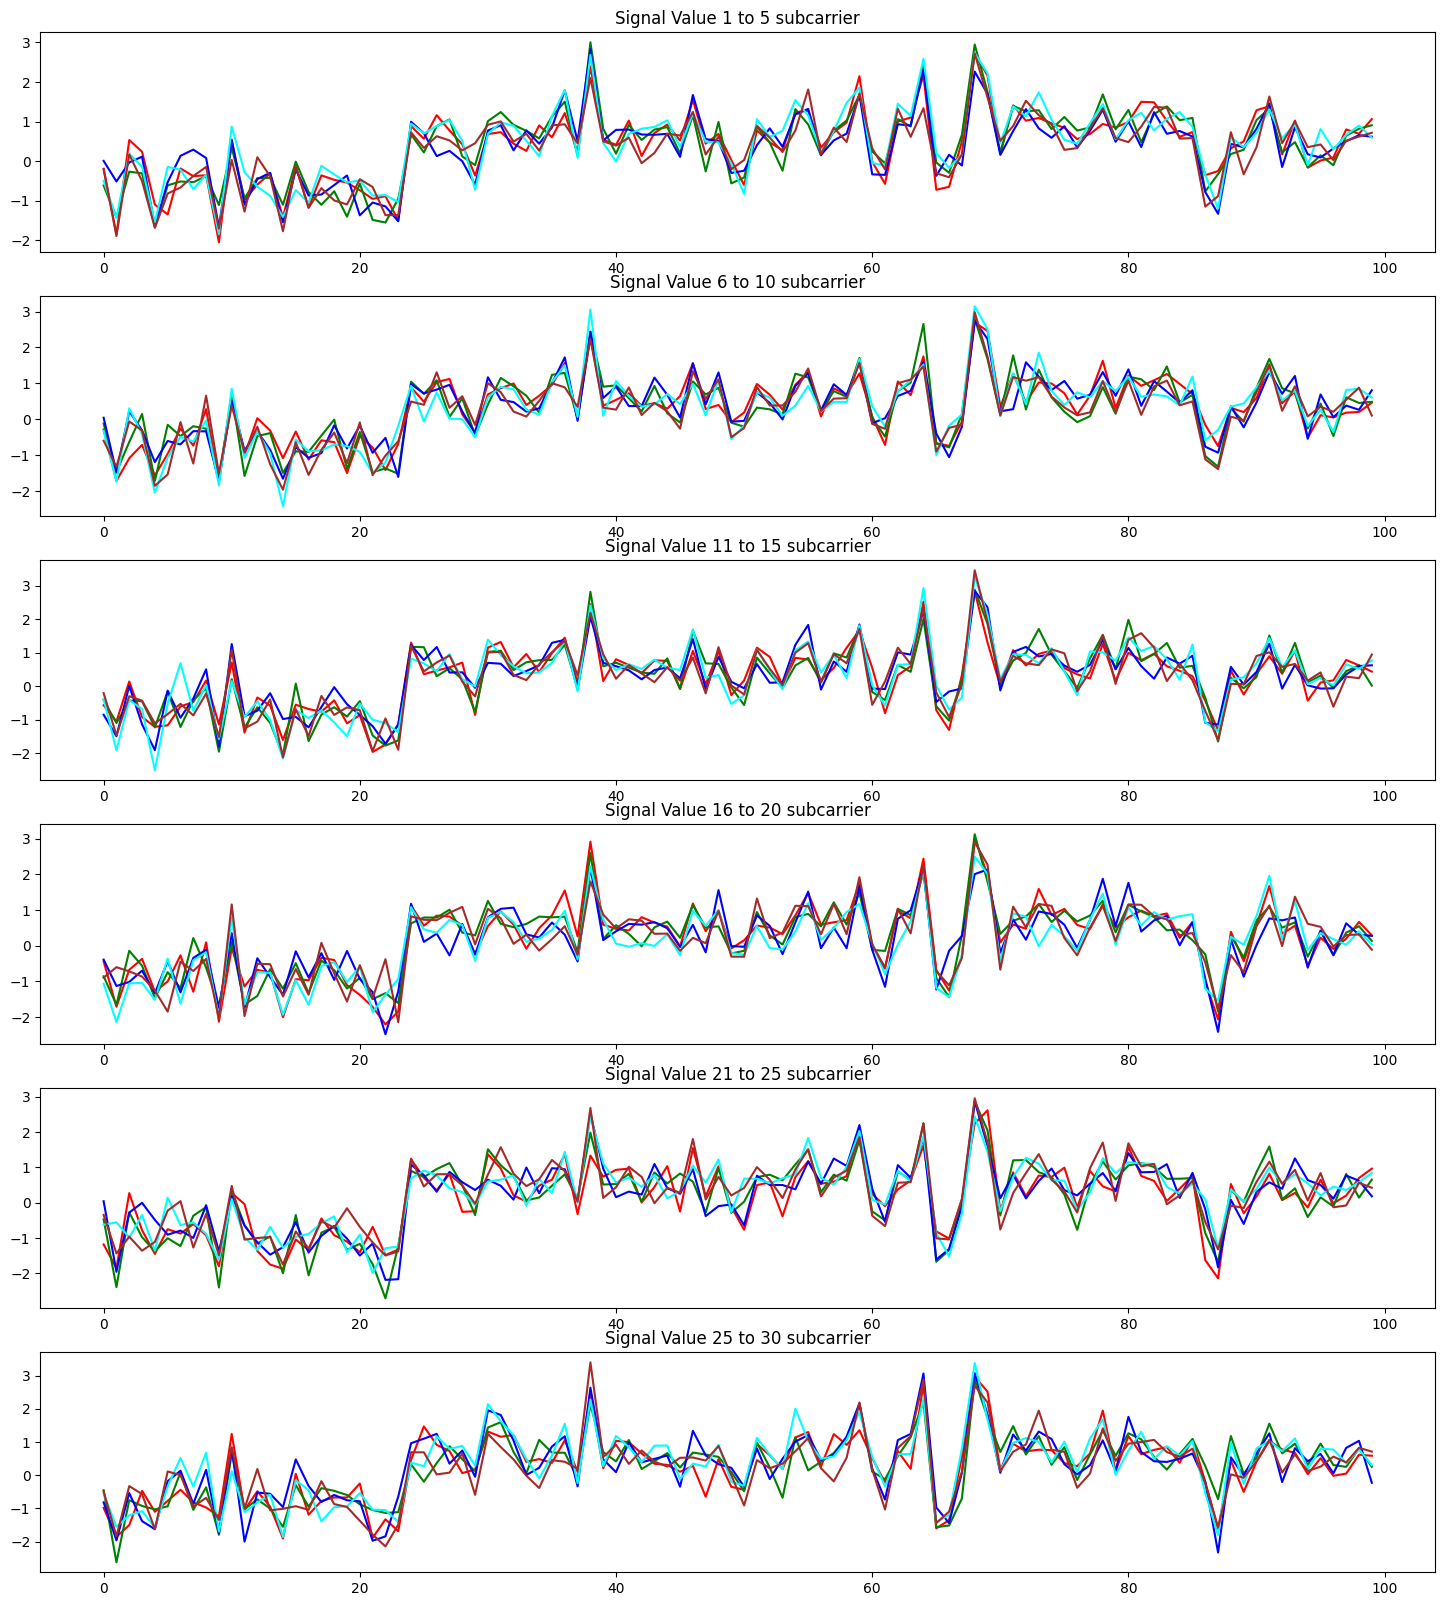

In [100]:
## Plot of amplitude of walking 400:500 i.e 1000 samples technically due to window_size
raw_sample_plot(scaled_data_walk_amps_df[400:500])

In [102]:
len(scaled_data_walk_amps_df)

1229

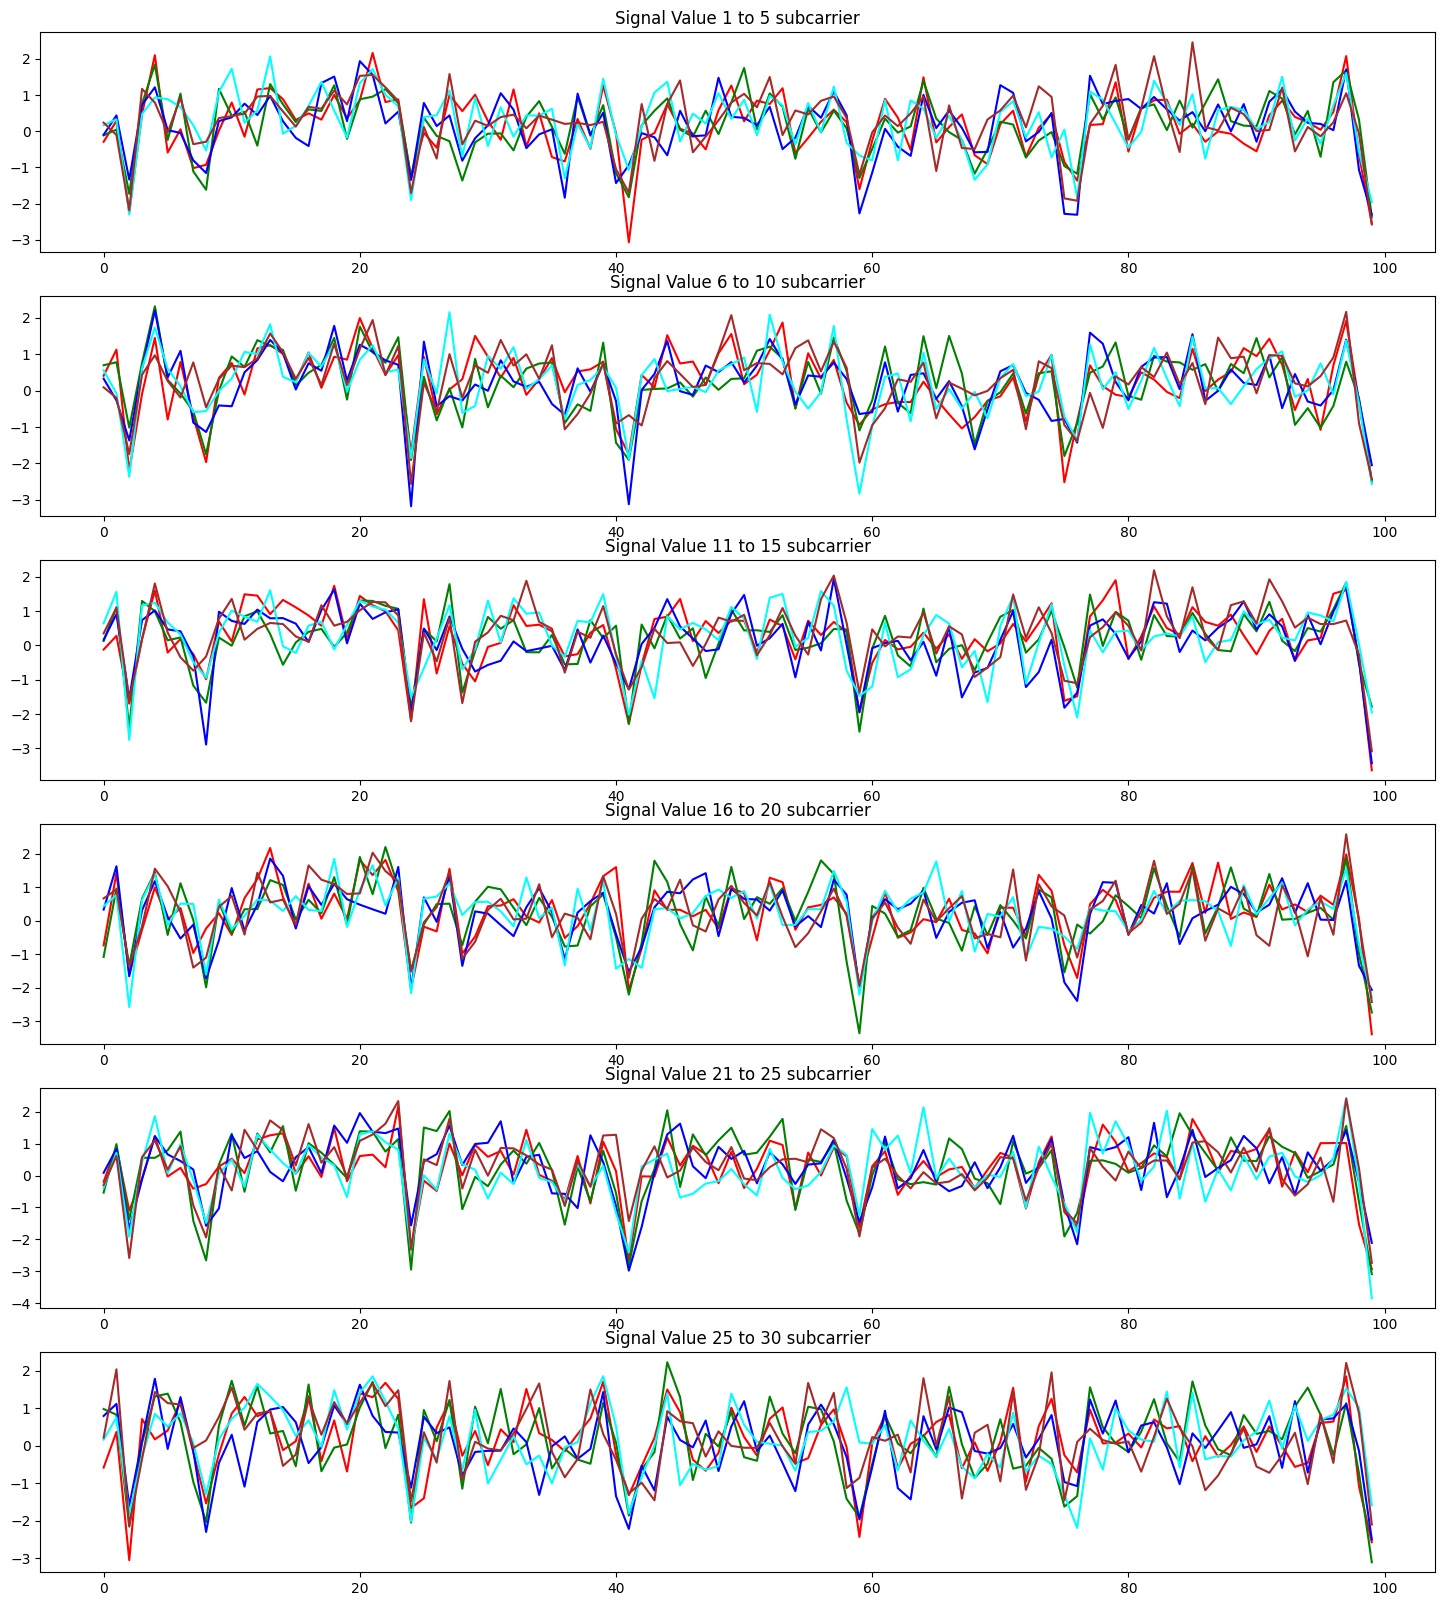

In [101]:
raw_sample_plot(scaled_data_jog_amps_df[400:500])

We can change the moving average window and also select larger interval.

### Plot data with PCA

In [107]:
## Select and plot pca scaled samples
def pca_visualization(new_sample):
    plt.figure(figsize = (18,20))

    ax1 = plt.subplot(611)
    plt.plot(new_sample[:,0])
    ax1.set_title("PCA 1st component")

    ax2 = plt.subplot(612)
    plt.plot(new_sample[:,1])
    ax2.set_title("PCA 2nd component")

    ax3 = plt.subplot(613)
    plt.plot(new_sample[:,2])
    ax3.set_title("PCA 3rd component")

    ax4 = plt.subplot(614)
    plt.plot(new_sample[:,3])
    ax4.set_title("PCA 4th component")

    ax5 = plt.subplot(615)
    plt.plot(new_sample[:,4])
    ax5.set_title("PCA 5th component")
    plt.show()

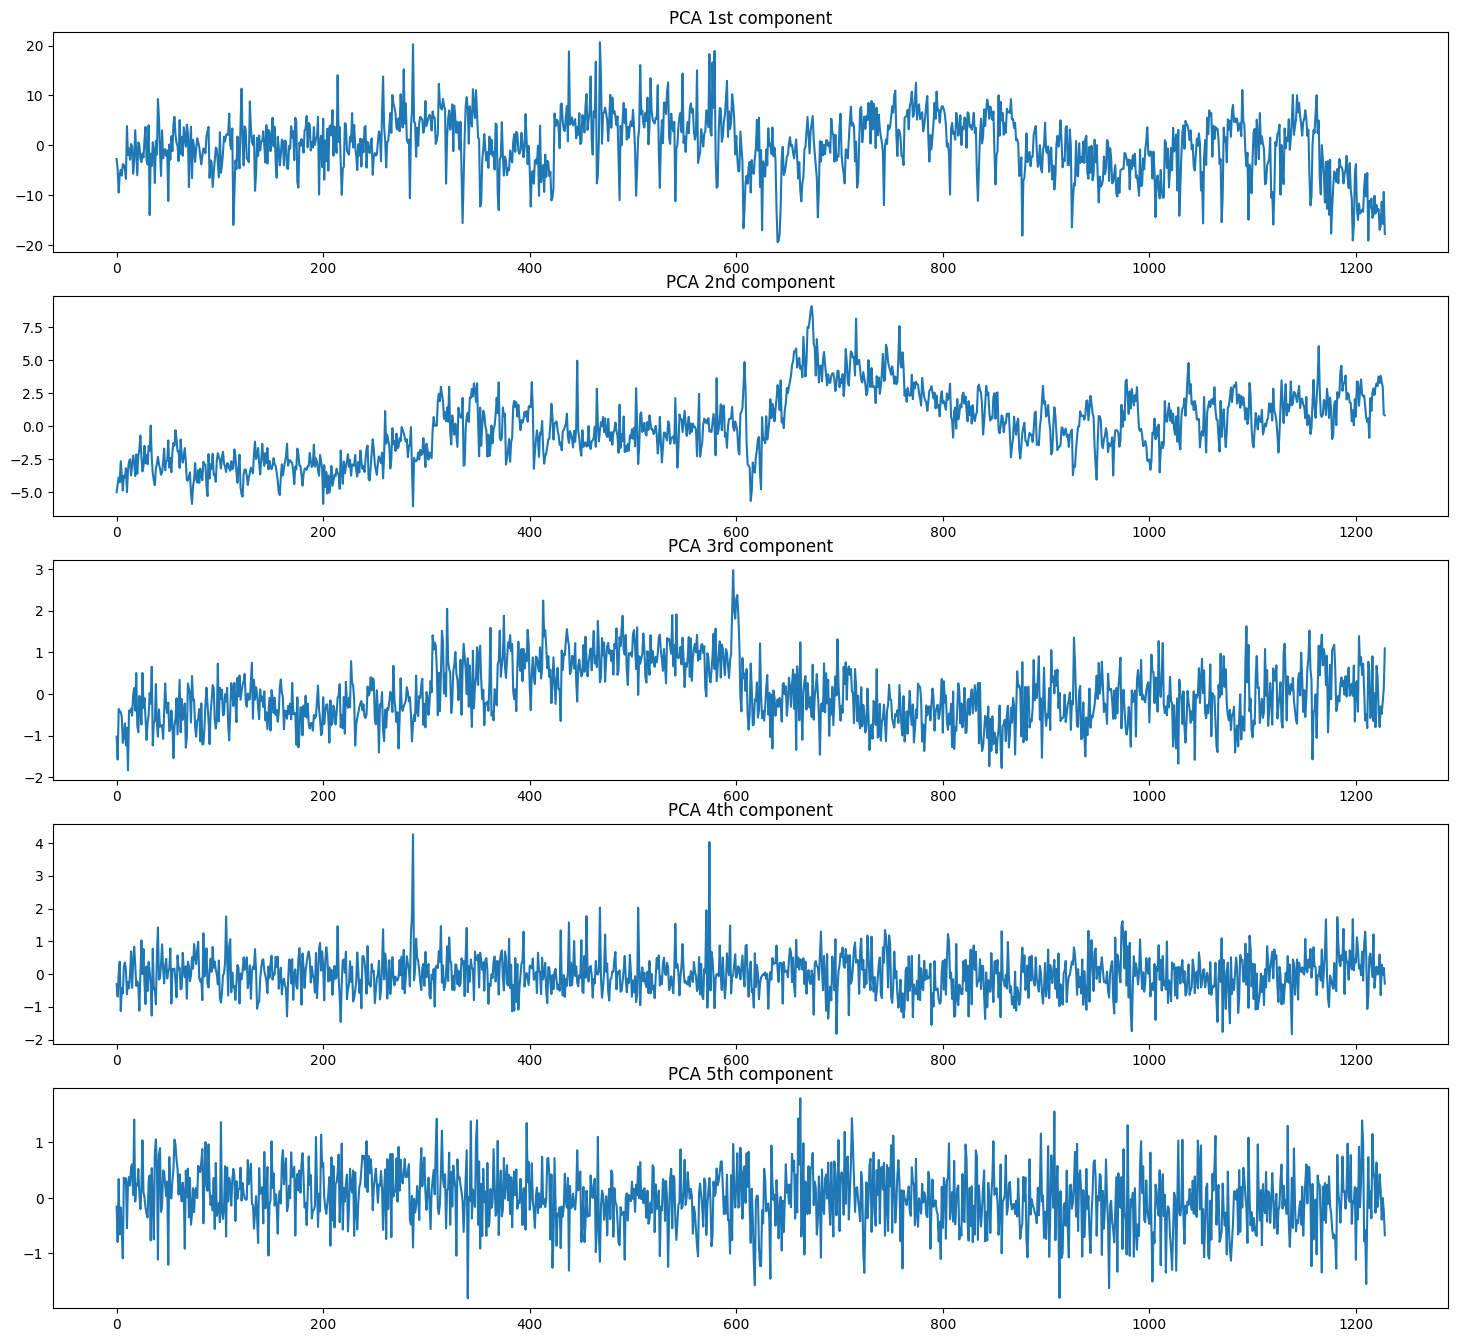

In [111]:
scaled_walk_amps_df = perform_scaling(mov_avg_walk_amps_df)
pca_obj, pca_walk_amps_df = perform_pca(scaled_walk_amps_df,n_components=5)
pca_visualization(pca_walk_amps_df)

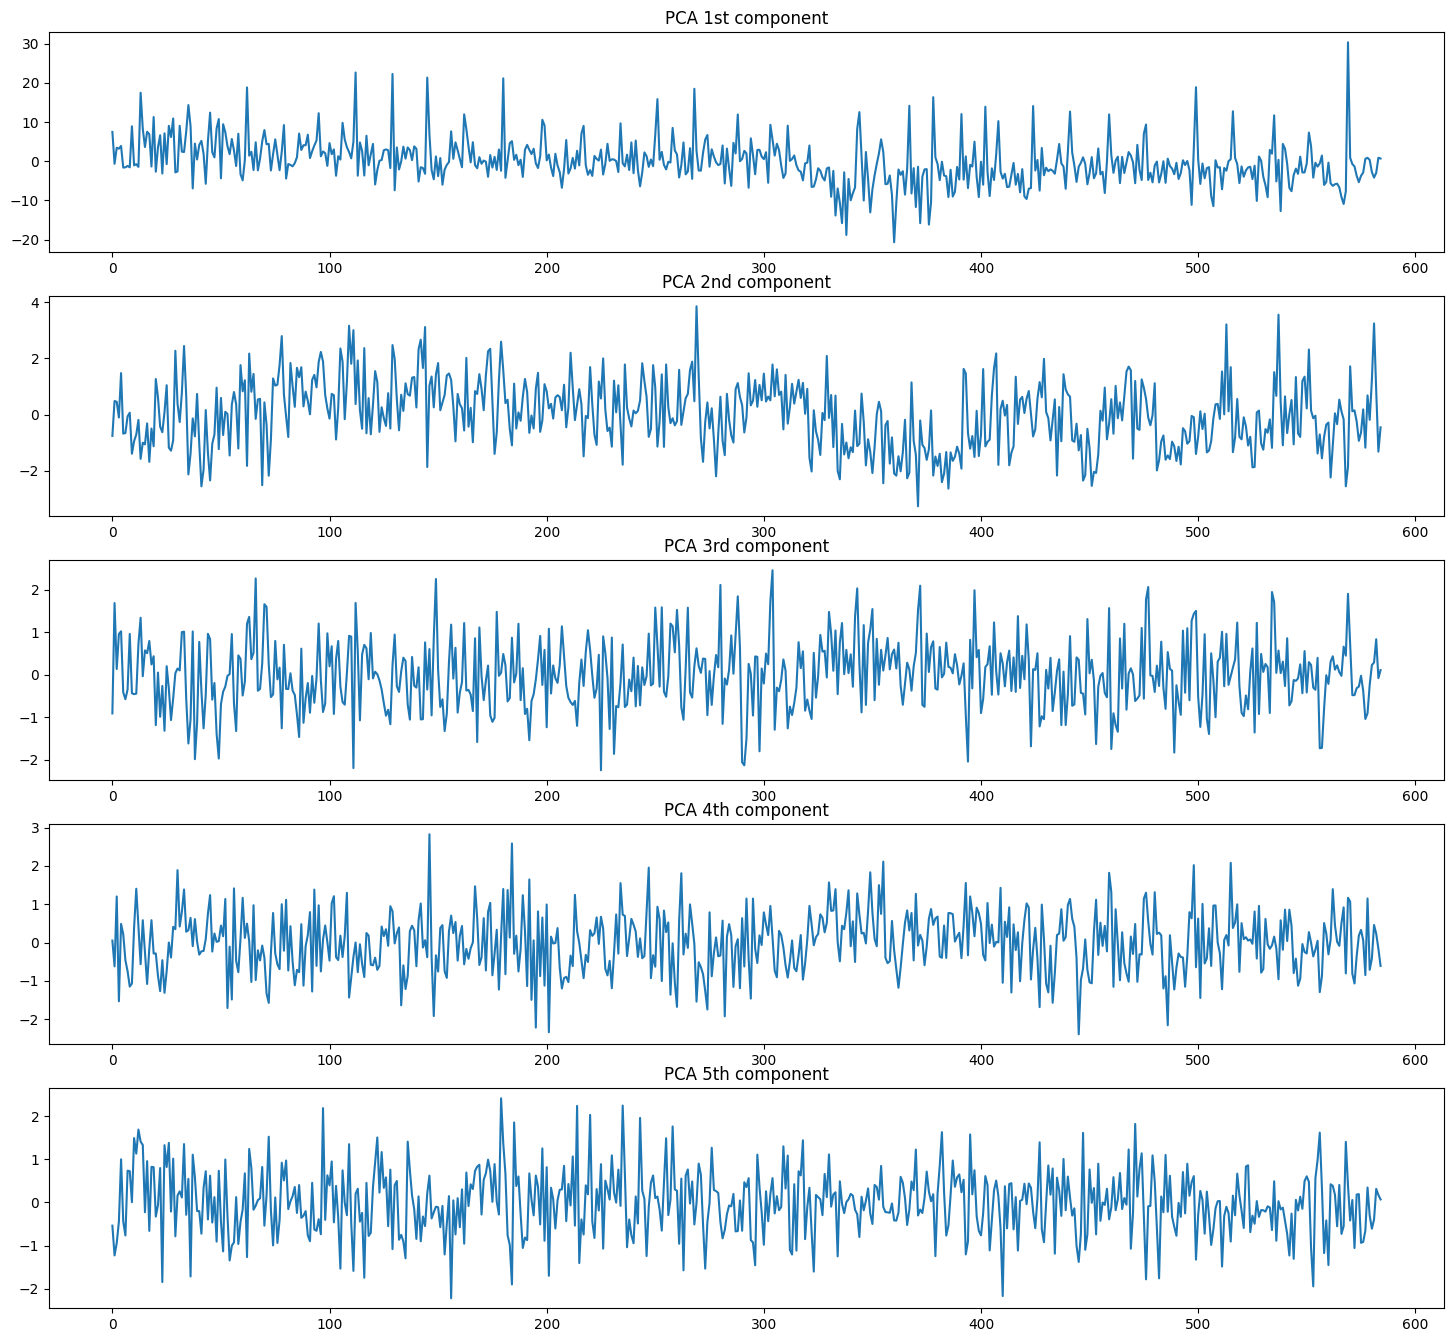

In [112]:
scaled_jog_amps_df = perform_scaling(mov_avg_jog_amps_df)
pca_obj, pca_jog_amps_df = perform_pca(scaled_jog_amps_df,n_components=5)
pca_visualization(pca_jog_amps_df)

### Frequency Domain Analysis

------

### Data Splitting for Model

In [ ]:
def train_test_split_data(X, y, test_size=0.2, random_state=42):
    """
    Split data into training and testing sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

### Model Creation

In [ ]:
def train_svm(X_train, y_train):
    """
    Train SVM model using the training data.
    """
    svm = SVC()
    svm.fit(X_train, y_train)
    return svm


def train_knn(X_train, y_train):
    """
    Train KNN model using the training data.
    """
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    return knn
